In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch

import torch.nn.functional as F
import cv2
from torch import nn

import cv2
from fastai.vision import *
from fastai.metrics import error_rate

from utils.pytorch_utils import AttentionConv, AttentionStem

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
# Change this to suit your environment
base_path = "/notebooks/storage/forestfire/data"

In [4]:
# Get images from S3 and unzip

# !cd {base_path} \
# && echo "Downloading files..." \
# && curl -O "https://sintecsys-omdena.s3.amazonaws.com/TTG_TUR.zip" \
# && echo "Unzipping files..." \
# && unzip -q -o "TTG_TUR.zip" \
# && echo "Changing file permissions" \
# && chmod u+rw -R "./TTG TUR"

In [5]:
# Create a dataframe containing the image paths and classification
image_paths = glob.glob(os.path.join(base_path + "/TTG TUR/","*.jpeg"))
data = []
for image_path in image_paths:
    label_name = image_path.split('.jpeg')[0][-3:]
    image_path=image_path
    label = -1
    if label_name == 'SIM':
        label = 1
    elif label_name == 'NAO':
        label = 0
    data.append((image_path, label))

# Shuffle the dataframe so the images will be randomly distributed in the 
image_df = pd.DataFrame(data, columns=["image_path", "label"]).sample(frac=1, random_state=12345).reset_index(). \
    drop(["index"], axis=1)
image_df["label"] = image_df["label"].astype(str)

image_df.head(5)

,image_path,label
0,/notebooks/storage/forestfire/data/TTG TUR/201...,1
1,/notebooks/storage/forestfire/data/TTG TUR/201...,1
2,/notebooks/storage/forestfire/data/TTG TUR/201...,0
3,/notebooks/storage/forestfire/data/TTG TUR/201...,0
4,/notebooks/storage/forestfire/data/TTG TUR/201...,0


In [6]:
train_valid_image_df, test_image_df = np.split(image_df.sample(frac=1), [int(0.8*len(image_df))])

In [7]:
print("Original dataset has", len(image_df), "images")
print("Training/Validation dataset has", len(train_valid_image_df), "images")
print("Test dataset has", len(test_image_df), "images")

Original dataset has 7525 images
Training/Validation dataset has 6020 images
Test dataset has 1505 images


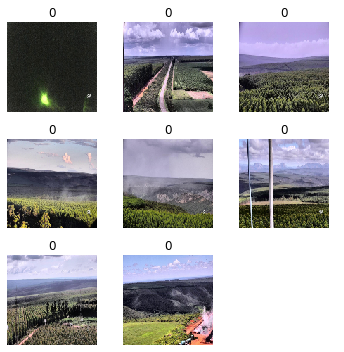

In [8]:
BATCH_SIZE = 8
data = ImageDataBunch.from_df("/", train_valid_image_df, valid_pct=0.25, seed=12345, label_col="label", size=(128, 128), bs=BATCH_SIZE)
data.show_batch(rows=10, figsize=(5,5))

In [34]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, groups=1, base_width=64):
        super(Bottleneck, self).__init__()
        self.stride = stride
        width = int(out_channels * (base_width / 64.)) * groups

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, width, kernel_size=1, bias=False),
            nn.BatchNorm2d(width),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            AttentionConv(width, width, kernel_size=7, padding=3, groups=8),
            nn.BatchNorm2d(width),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(width, self.expansion * out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.expansion * out_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.stride >= 2:
            out = F.avg_pool2d(out, (self.stride, self.stride))

        out += self.shortcut(x)
        out = F.relu(out)

        return out


class Model(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000, stem=False):
        super(Model, self).__init__()
        self.in_places = 64

        if stem:
            self.init = nn.Sequential(
                # CIFAR10
                #AttentionStem(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=2, groups=1),
                #nn.BatchNorm2d(64),
                #nn.ReLU(),

                # For ImageNet
                AttentionStem(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=2, groups=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(4, 4)
            )
        else:
            self.init = nn.Sequential(
                # CIFAR10
                #nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                #nn.BatchNorm2d(64),
                #nn.ReLU(),

                # For ImageNet
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            )

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dense = nn.Linear(512 * block.expansion, num_classes)
        self.sigmoid1 = nn.Sigmoid()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_places, planes, stride))
            self.in_places = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        out = self.sigmoid1(out)

        return out


def ResNet26(num_classes=1000, stem=False):
    return Model(Bottleneck, [1, 2, 4, 1], num_classes=num_classes, stem=stem)


def ResNet38(num_classes=1000, stem=False):
    return Model(Bottleneck, [2, 3, 5, 2], num_classes=num_classes, stem=stem)


def ResNet50(num_classes=1000, stem=False):
    return Model(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, stem=stem)


temp = torch.randn((2, 3, 128, 128))
model = ResNet38(num_classes=1, stem=True)

TypeError: __init__() got an unexpected keyword argument 'dim'

In [31]:
learn = Learner(data, model, loss_func = nn.BCEWithLogitsLoss(), metrics=accuracy, wd = 1e-2).to_fp16()

In [32]:
learn.summary()

Model
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 132, 132]       192        True      
______________________________________________________________________
Conv2d               [64, 128, 128]       192        True      
______________________________________________________________________
Conv2d               [64, 132, 132]       192        True      
______________________________________________________________________
Conv2d               [64, 132, 132]       192        True      
______________________________________________________________________
Conv2d               [64, 132, 132]       192        True      
______________________________________________________________________
Conv2d               [64, 132, 132]       192        True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
________________________________________________________

In [33]:
# learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: Target size (torch.Size([8])) must be the same as input size (torch.Size([8, 1]))

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-4))

In [ ]:
learn.save('stage-resnet_1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
preds,y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
interp = ClassificationInterpretation(learn, preds, y_true , losses)

In [ ]:
interp.plot_top_losses(25, figsize=(15,11))

In [ ]:
preds=preds.numpy()
preds =preds[:,1]

In [ ]:
y_preds = []
for i in preds:
    if i >=0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)

In [ ]:
y_pred= np.asarray(y_preds)
TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
statistics = []
stats = { 'TP' : TP,
                'TN' : TN,
                'FP' : FP,
                'FN' : FN}

statistics.append(stats)
statistics

In [ ]:
accuracy = (TP + TN) / (TN + TP + FN + FP)
recall = TP / (TP + FN)
precision =  TP / (TP + FP)

In [ ]:
print(50*'-')
print('Accuracy: {0:.2f}'.format(accuracy))

print(50*'-')
print('Recall: {0:.2f}'.format(recall))

print(50*'-')
print('Precision: {0:.2f}'.format(precision))

In [ ]:
DR = TP / (TN + TP + FN + FP) *100
FAR=FP/(TP+FP)*100
AR = (TP+TN)/(TN + TP + FN + FP)*100
print('Detection Rate:{0:.2f}'.format(DR))
print('False Alarm Rate:{0:.2f}'.format(FAR))
print('Accuracy Rate:{0:.2f}'.format(AR))